In [ ]:
# %%capture
try:
  from torch_snippets import *
except:
  %pip install torch-snippets gitPython lovely-tensors
  from torch_snippets import *

from git import Repo

repository_url = 'https://github.com/sizhky/quantization'
destination_directory = '/content/quantization'
if exists(destination_directory):
  repo = Repo(destination_directory)
else:
  repo = Repo.clone_from(repository_url, destination_directory)

%cd {destination_directory}
%pip install -qq -r requirements.txt # this will take about 5 min of time
# print(repo.git.pull('origin', 'main'))

/content/quantization


# Train

In [ ]:
import torch_tensorrt
torch_tensorrt.__version__


'2.2.0'

In [ ]:
# Change to `Debug=false` in the line below
# to train on a larger dataset
%env DEBUG=true
!make train

env: DEBUG=true
python -m src.defect_classification.train
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100% 528M/528M [00:07<00:00, 71.7MB/s]
Generating train split: 100% 2331/2331 [00:04<00:00, 520.71 examples/s]
Generating valid split: 100% 1004/1004 [00:00<00:00, 1006.59 examples/s]
Class Balance


# Benchmarks

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!make basic-benchmark
# visit makefile for the actual python command

python -m src.defect_classification.basic_benchmark
Started computing roc auc score...
ROC AUC Score: 0.89
Started benchmarks...
Average batch time: 120.27 ms


```python
model = torch.load('model.pth').eval()

input_shape = (32,3,224,224)
trt_model_hp = torch_tensorrt.compile(
    model,
    inputs=[torch_tensorrt.Input(input_shape)],
    enabled_precisions= {torch_tensorrt.dtype.half} # Run with FP16
)

from sklearn.metrics import roc_auc_score
from datasets import load_dataset
from src.defect_classification.train import process_example, DefectsDataset

def get_roc_auc_score(model):
    print("Started computing roc auc score...")
    predictions, actuals = [], []

    val_ds = load_dataset('sizhkhy/kolektor_sdd2', split="valid[:50]+valid[-50:]")
    val_ds = val_ds.map(process_example).remove_columns(['split', 'path'])
    val_ds.set_format("pt", columns=["image", "label"], output_all_columns=True)
    val_ds = DefectsDataset(val_ds)
    val_dl = DataLoader(val_ds, batch_size=32, shuffle=True, drop_last=True)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        if isinstance(model, nn.Module):
          prediction = model(x.cuda()).detach().cpu().numpy().tolist()
        else: # half/int8 model
          prediction = model(x.cuda())[0].detach().cpu().numpy().tolist()
        predictions.extend(prediction)
        actuals.extend(y.detach().cpu().numpy().tolist())

    actuals = flatten(actuals)
    predictions = flatten(predictions)
    print(f"ROC AUC Score: {roc_auc_score(actuals, predictions):.2f}")

get_roc_auc_score(trt_model_hp)

import time

@torch.no_grad()
def benchmark(model, input_shape=(32, 3, 224, 224), nwarmup=5, nruns=100):
    print("Started benchmarks...")
    input_data = torch.randn(input_shape)
    input_data = input_data.to("cuda")
    for _ in range(nwarmup):
        model(input_data)
    torch.cuda.synchronize()

    timings = []
    for _ in range(nruns):
        start_time = time.perf_counter()
        model(input_data)
        end_time = time.perf_counter()
        timings.append(end_time - start_time)
    timing = np.mean(timings)*1000
    print(f'Average batch time: {timing:.2f} ms')

benchmark(trt_model_hp)
```

In [ ]:
!make fp16-benchmark
# visit makefile for the actual python command

python -m src.defect_classification.fp16_benchmark
INFO:datasets:PyTorch version 2.2.1+cu121 available.
INFO:datasets:TensorFlow version 2.15.0 available.
INFO:datasets:JAX version 0.4.23 available.
Loading trt model...
INFO:torch_tensorrt._compile:ir was set to default, using dynamo as ir
INFO:torch_tensorrt.dynamo._compiler:Compilation Settings: CompilationSettings(precision=torch.float16, debug=False, workspace_size=0, min_block_size=5, torch_executed_ops=set(), pass_through_build_failures=False, max_aux_streams=None, version_compatible=False, optimization_level=None, use_python_runtime=False, truncate_long_and_double=False, use_fast_partitioner=True, enable_experimental_decompositions=False, device=Device(type=DeviceType.GPU, gpu_id=0), require_full_compilation=False, disable_tf32=False, sparse_weights=False, refit=False, engine_capability=<EngineCapability.DEFAULT: 0>, num_avg_timing_iters=1, dla_sram_size=1048576, dla_local_dram_size=1073741824, dla_global_dram_size=536870912, ou

# Measuring Data Drift

In [ ]:
from torch_snippets import *
from src.defect_classification.train import get_datasets, get_dataloaders

trn_ds, val_ds = get_datasets(DEBUG=True)
trn_dl, val_dl = get_dataloaders(trn_ds, val_ds)

model = torch.load('model.pth').cuda().eval()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Class Balance
 
```↯ AttrDict ↯
train
  non_defect - 50 (int)
  defect - 50 (int)
valid
  non_defect - 50 (int)
  defect - 50 (int)

```

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
results = []
for ix, batch in enumerate(iter(trn_dl)):
  inter = model.avgpool(model.features(batch[0].cuda()))[:,:,0,0].detach().cpu().numpy()
  results.append(inter)
results = np.array(results)
results = results.reshape(-1, 512)

In [ ]:
im = val_ds[0]['image'][None].cuda()
tmp = np.array(model.avgpool(model.features(im))[0,:,0,0].detach().cpu().numpy())
dists1 = np.sum(np.abs(results - tmp), axis=1)

In [ ]:
path = '/content/sample_defects.jpg'
if not os.path.exists(path):
  !wget https://as2.ftcdn.net/v2/jpg/01/42/16/37/1000_F_142163797_YxZaY95j5ckLgb6KoM5KC11Eh9QiZsYx.jpg -O /content/sample_defects.jpg

im = (cv2.imread(path)[:,:,::-1])
im = cv2.resize(im, (224,224))
im = torch.tensor(im/255)
im = im.permute(2,0,1).float().to(device)
im = im.view(1,3,224,224)

tmp = np.array(model.avgpool(model.features(im))[0,:,0,0].detach().cpu().numpy())
dists2 = np.sum(np.abs(results - tmp), axis=1)

--2024-03-25 20:53:21--  https://as2.ftcdn.net/v2/jpg/01/42/16/37/1000_F_142163797_YxZaY95j5ckLgb6KoM5KC11Eh9QiZsYx.jpg
Resolving as2.ftcdn.net (as2.ftcdn.net)... 151.101.1.167, 151.101.65.167, 151.101.129.167, ...
Connecting to as2.ftcdn.net (as2.ftcdn.net)|151.101.1.167|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 428083 (418K) [image/jpeg]
Saving to: ‘/content/sample_defects.jpg’

/content/sample_def 100%[===================>] 418.05K  --.-KB/s    in 0.02s   

2024-03-25 20:53:21 (16.5 MB/s) - ‘/content/sample_defects.jpg’ saved [428083/428083]



<Axes: xlabel='distance', ylabel='source'>

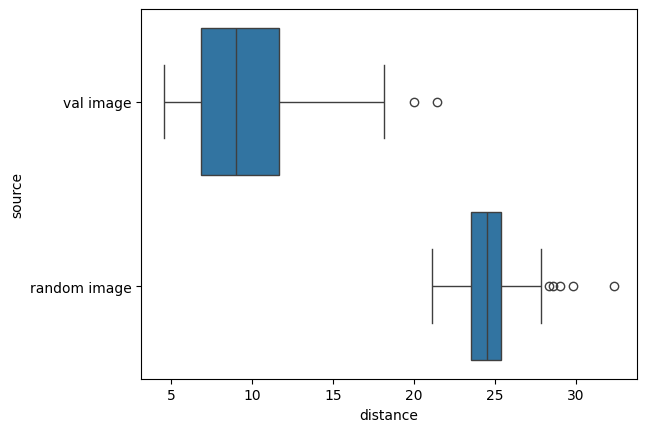

In [ ]:
import seaborn as sns

df = pd.DataFrame(
    {'distance': np.r_[dists1, dists2],
     'source': ['val image']*len(dists1)+['random image']*len(dists2)})
# Just switch x and y
sns.boxplot(y=df["source"], x=df["distance"])

# Vector Store

In [ ]:
import faiss
import numpy as np

index = faiss.IndexFlatL2(results.shape[1])  # L2 distance
index.add(results)
faiss.write_index(index, "index_file.index")
query_vector = tmp.reshape(1,512).astype('float32')

In [ ]:
%%time
k = 3  # Number of nearest neighbors to retrieve
D, I = index.search(query_vector.astype('float32'), k)

CPU times: user 121 µs, sys: 12 µs, total: 133 µs
Wall time: 150 µs


## Vector Store on 960k vectors instead of 96

In [ ]:
vectors = np.array(results.tolist()*10000, dtype=np.float32)
print(vectors.shape)
index = faiss.IndexFlatL2(vectors.shape[1])  # L2 distance
index.add(vectors)
faiss.write_index(index, "index_file_960k.index")

(960000, 512)

In [ ]:
%%time
k = 3  # Number of nearest neighbors to retrieve
D, I = index.search(query_vector.astype('float32'), k)

CPU times: user 652 ms, sys: 8.83 ms, total: 661 ms
Wall time: 661 ms


In [ ]:
%%time
distances = np.sum(np.square(query_vector - vectors), axis=1)
sorted_distances = np.sort(distances)

CPU times: user 909 ms, sys: 4.16 s, total: 5.07 s
Wall time: 5.08 s


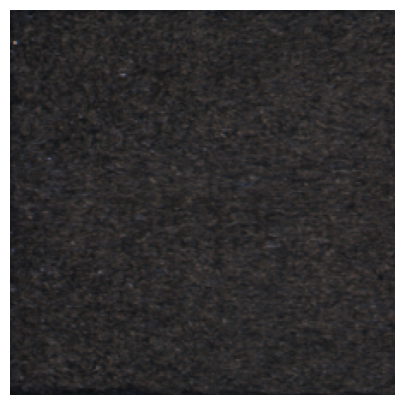

In [ ]:
im = val_ds[0]['image'][None].cuda()[0]

show(im)